In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv('train.csv')
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
data.shape

(7613, 5)

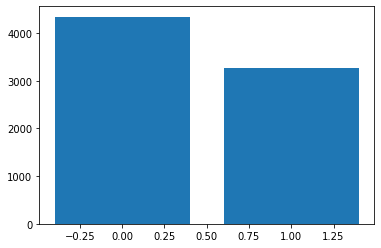

In [21]:
plt.bar(*np.unique(data.target, return_counts=True))
plt.show()

In [26]:
rs = np.random.RandomState(np.random.MT19937(np.random.SeedSequence(1234)))
data_shuffled = data.sample(frac=1, random_state=rs)

In [57]:
train = data_shuffled[:(data_shuffled.shape[0]*2//3)+1]
train = train.reset_index(drop=True)
test = data_shuffled[(data_shuffled.shape[0]*2//3)+1:]
test = test.reset_index(drop=True)

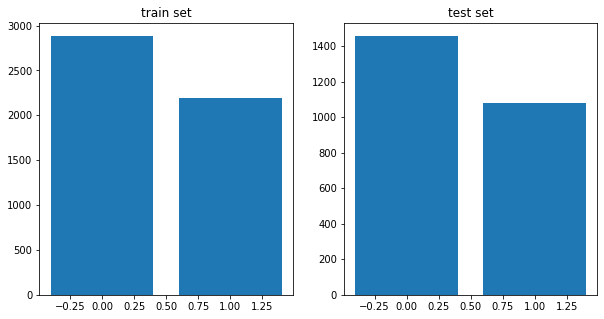

In [58]:
_, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].bar(*np.unique(train.target, return_counts=True))
ax[0].set_title('train set')
ax[1].bar(*np.unique(test.target, return_counts=True))
ax[1].set_title('test set')
plt.show()

## Tokenizacja

In [42]:
!pip install transformers

     |████████████████████████████████| 2.3MB 7.7MB/s 
     |████████████████████████████████| 901kB 47.7MB/s 
     |████████████████████████████████| 3.3MB 35.5MB/s 


In [44]:
from transformers import BertTokenizer

In [45]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [69]:
def encode_tweet(tweet):
  tokens = tokenizer.tokenize(tweet)
  return tokenizer.convert_tokens_to_ids(tokens)

In [63]:
train.text[1]

"only had a car for not even a week and got in a fucking car accident .. Mfs can't fucking drive ."

In [71]:
encode_tweet(train.text[1])

[1178,
 1125,
 170,
 1610,
 1111,
 1136,
 1256,
 170,
 1989,
 1105,
 1400,
 1107,
 170,
 8750,
 1610,
 4216,
 119,
 119,
 150,
 22816,
 1169,
 112,
 189,
 8750,
 2797,
 119]

In [77]:
from keras.preprocessing.sequence import pad_sequences

In [82]:
def len_stat_summary(texts):
  text_len = [len(text) for text in texts]
  max_len = np.max(text_len)
  min_len = np.min(text_len)
  avg_len = np.average(text_len)
  std_len = np.std(text_len)
  print(f'max = {max_len}; min = {min_len}; avg = {avg_len}; std = {std_len}')

In [84]:
print('Tweets lengths:')
print('Train set:')
len_stat_summary(train.text)
print('Test set:')
len_stat_summary(test.text)

Tweets lengths:
Train set:
max = 157; min = 7; avg = 101.42415287628053; std = 33.63061231796529
Test set:
max = 148; min = 8; avg = 100.26369728025227; std = 34.06109067134413


In [86]:
PADDING_LEN = 75

In [92]:
encoded_tweets = {
    'train' : {
        'tweet' : pad_sequences(np.array([encode_tweet(tweet) for tweet in train.text]), maxlen=PADDING_LEN),
        'target' : train.target
    },
    'test' : {
        'tweet' : pad_sequences(np.array([encode_tweet(tweet) for tweet in test.text]), maxlen=PADDING_SIZE),
        'target' : test.target
    }
}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


## Prosta sieć CNN

In [89]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense

In [93]:
model = Sequential()

model.add(Embedding(output_dim=32, 
                    input_dim=tokenizer.vocab_size, 
                    input_length=75))
model.add(Conv1D(filters=32,
                 kernel_size=3,
                 padding='same',
                 activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(units=37,
                activation='relu'))
model.add(Dense(units=1,
                activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(encoded_tweets['train']['tweet'],
          encoded_tweets['train']['target'],
          validation_data=(
              encoded_tweets['train']['tweet'],
              encoded_tweets['train']['target']),
          epochs=2, 
          batch_size=128)
loss, accuracy = model.evaluate(encoded_tweets['test']['tweet'],
                                encoded_tweets['test']['target'])
print("Trafność klasyfikacji to: {acc}%".format(acc=accuracy*100))

Epoch 1/2
40/40 [==============================] - 2s 34ms/step - loss: 0.6731 - accuracy: 0.5685 - val_loss: 0.6210 - val_accuracy: 0.6755
Epoch 2/2
80/80 [==============================] - 0s 2ms/step - loss: 0.5537 - accuracy: 0.7075
Trafność klasyfikacji to: 70.75285911560059%


Inne parametry

In [101]:
model = Sequential()

model.add(Embedding(output_dim=35, 
                    input_dim=tokenizer.vocab_size, 
                    input_length=75))
model.add(Conv1D(filters=35,
                 kernel_size=5,
                 padding='same',
                 activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(units=37,
                activation='relu'))
model.add(Dense(units=1,
                activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(encoded_tweets['train']['tweet'],
          encoded_tweets['train']['target'],
          validation_data=(
              encoded_tweets['train']['tweet'],
              encoded_tweets['train']['target']),
          epochs=2, 
          batch_size=128)
loss, accuracy = model.evaluate(encoded_tweets['test']['tweet'],
                                encoded_tweets['test']['target'])
print("Trafność klasyfikacji to: {acc}%".format(acc=accuracy*100))

Epoch 1/2
40/40 [==============================] - 2s 48ms/step - loss: 0.6751 - accuracy: 0.5711 - val_loss: 0.6023 - val_accuracy: 0.7007
Epoch 2/2
80/80 [==============================] - 0s 3ms/step - loss: 0.5220 - accuracy: 0.7402
Trafność klasyfikacji to: 74.02443885803223%
